<a href="https://colab.research.google.com/github/cloverbunny/cccf2025/blob/main/CCCF_Datathon_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating the `tableone` package

In [1]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
auth.authenticate_user()

In [3]:
# Note that this should be the project for the datathon work,
# not the physionet-data project which is for data hosting.
project_id = 'silent-bolt-397621'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

In [4]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [6]:
!pip install tableone
from tableone import TableOne
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
query = """
WITH icu AS (
  SELECT
    stay_id,
    subject_id,
    hadm_id,
    intime,
    outtime,
    los AS LOS  -- already in days
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
  WHERE outtime IS NOT NULL
AND los > (2/24)
),

sex AS (
  SELECT subject_id, MAX(gender) AS gender
  FROM `physionet-data.mimiciv_3_1_hosp.patients`
  WHERE subject_id IN (SELECT subject_id FROM icu)
  GROUP BY subject_id
),

age AS (
  SELECT subject_id, MAX(age) AS age
  FROM `physionet-data.mimiciv_3_1_derived.age`
  WHERE subject_id IN (SELECT subject_id FROM icu)
  GROUP BY subject_id
),

apache AS (
  SELECT stay_id, MAX(apsiii) AS apache
  FROM `physionet-data.mimiciv_3_1_derived.apsiii`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
),

mechvent AS (
  SELECT stay_id, 1 AS mech_vent
  FROM `physionet-data.mimiciv_3_1_derived.ventilation`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
),

death AS (
  SELECT subject_id, MAX(hospital_expire_flag) AS died
  FROM `physionet-data.mimiciv_3_1_hosp.admissions`
  WHERE subject_id IN (SELECT subject_id FROM icu)
  GROUP BY subject_id
)

SELECT
  icu.stay_id,
  icu.subject_id,
  age.age,
  sex.gender,
  icu.los,
  apache.apache,
  IFNULL(mechvent.mech_vent, 0) AS mech_vent,
  death.died
FROM icu
LEFT JOIN age USING (subject_id)
LEFT JOIN sex USING (subject_id)
LEFT JOIN apache USING (stay_id)
LEFT JOIN mechvent USING (stay_id)
LEFT JOIN death USING (subject_id);
"""

df = run_query(query)

df.head()

In [195]:
df = df.rename(columns={
    'age': 'Age',
    'gender': 'Sex',
    'los': 'LOS',
    'apache': 'APACHE',
    'mech_vent': 'Mechanical Ventilation',
    'died': 'Death'
})

In [196]:
from tableone import TableOne

vars = ['Age', 'Sex', 'LOS', 'APACHE', 'Mechanical Ventilation', 'Death']
cat_vars = ['Sex', 'Mechanical Ventilation', 'Death']

table1 = TableOne(df, columns=vars, categorical=cat_vars, missing=False, show_histograms=True)

print(table1)


                                      Overall Histogram
n                                       94134          
Age, mean (SD)                    65.9 (16.7)  ▂▂▃▅▇█▆▅
Sex, n (%)                    F  41418 (44.0)          
                              M  52716 (56.0)          
LOS, mean (SD)                      3.6 (5.4)  █▂▁▁▁▁▁▁
APACHE, mean (SD)                 43.4 (20.4)  ▅█▆▄▂▂▁▁
Mechanical Ventilation, n (%) 0  23375 (24.8)          
                              1  70759 (75.2)          
Death, n (%)                  0  76471 (81.2)          
                              1  17663 (18.8)          



In [197]:
from IPython.display import display, HTML
display(HTML(table1.to_html()))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

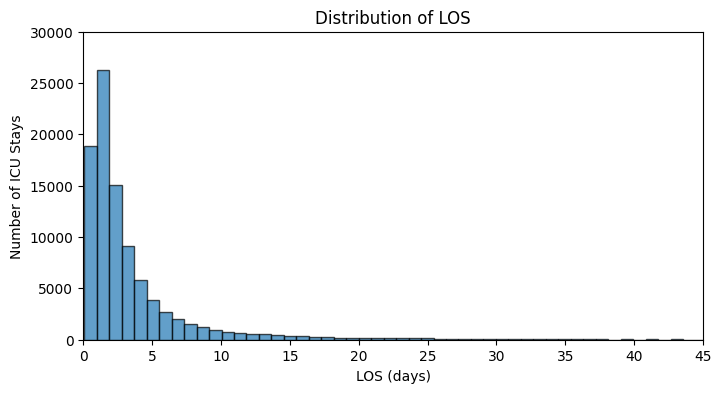

In [198]:
import matplotlib.pyplot as plt

df[['LOS']].dropna().plot.hist(
    bins=250,
    figsize=[8,4],
    alpha=0.7,
    edgecolor='black',
    legend=False
)

plt.xlim([0,45])
plt.ylim([0,30000])
plt.xlabel('LOS (days)')
plt.ylabel('Number of ICU Stays')
plt.title('Distribution of LOS')

plt.savefig('los_distribution.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('los_distribution.png')

plt.show()


In [74]:
import os
cwd = os.getcwd()
print("Current working directory:", cwd)
from google.colab import files
files.download('/content/los_distribution.png')

Current working directory: /content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

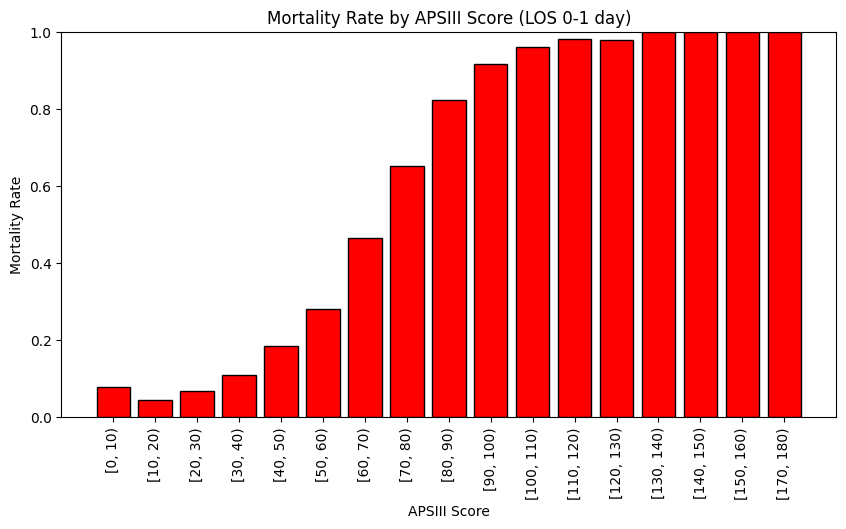

    APACHE_bin  n_patients  n_deaths  mortality_rate
0      [0, 10)         151        12         0.07947
1     [10, 20)        1676        73        0.043556
2     [20, 30)        4997       342        0.068441
3     [30, 40)        5112       563        0.110133
4     [40, 50)        3503       651        0.185841
5     [50, 60)        1679       470        0.279929
6     [60, 70)         828       386        0.466184
7     [70, 80)         446       291        0.652466
8     [80, 90)         305       251        0.822951
9    [90, 100)         231       212        0.917749
10  [100, 110)         157       151        0.961783
11  [110, 120)         111       109        0.981982
12  [120, 130)          51        50        0.980392
13  [130, 140)          32        32             1.0
14  [140, 150)          15        15             1.0
15  [150, 160)          10        10             1.0
16  [160, 170)           0         0            <NA>
17  [170, 180)           1         1          

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter LOS 0-1 day group and drop missing values
day0_1 = df_filtered[df_filtered['LOS_group'] == '0-1 day'].copy()
day0_1 = day0_1.dropna(subset=['APACHE', 'Death'])

# 2. Bin APACHE scores
bin_width = 10
bins = np.arange(0, day0_1['APACHE'].max() + bin_width, bin_width)
day0_1['APACHE_bin'] = pd.cut(day0_1['APACHE'], bins=bins, right=False)

# 3. Calculate mortality rate per bin
mortality_by_bin = day0_1.groupby('APACHE_bin', observed=False)['Death'].mean().reset_index()

# 3b. Drop any NaN bins
mortality_by_bin = mortality_by_bin.dropna(subset=['APACHE_bin', 'Death'])

# 4. Plot mortality rate histogram
plt.figure(figsize=(10,5))
plt.bar(mortality_by_bin['APACHE_bin'].astype(str), mortality_by_bin['Death'],
        color='red', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('APSIII Score')
plt.ylabel('Mortality Rate')
plt.title('Mortality Rate by APSIII Score (LOS 0-1 day)')
plt.ylim(0, 1)

plt.savefig('los_mortalityrate_APACHE.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('los_mortalityrate_APACHE.png')

plt.show()

# 1. Count number of patients per bin
patients_per_bin = day0_1.groupby('APACHE_bin', observed=False).agg(
    n_patients=('Death', 'count'),   # count all patients in the bin
    n_deaths=('Death', 'sum'),       # optional: sum of deaths
    mortality_rate=('Death', 'mean') # optional: mean = mortality rate
).reset_index()

# 2. Drop NaN bins if needed
patients_per_bin = patients_per_bin.dropna(subset=['APACHE_bin'])

# 3. Display
print(patients_per_bin)

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter LOS > 0
df_filtered = df[df['LOS'] > 0].copy()
df_filtered.head()

# 2. Create LOS groups
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, df_filtered['LOS'].max()+1]  # 12 edges → 11 bins
labels = ['0-1 day', '1-2 days', '2-3 days', '3-4 days', '4-5 days', '5-6 days',
          '6-7 days', '7-8 days', '8-9 days', '9-10 days', '10+ days']  # 11 labels
df_filtered['LOS_group'] = pd.cut(df_filtered['LOS'], bins=bins, labels=labels, right=False)

# 3. Group by LOS_group
summary_table = df_filtered.groupby('LOS_group').agg(
    n_patients=('Death', 'count'),
    n_deaths=('Death', 'sum')
).reset_index()

# 4. Calculate mortality rate
summary_table['mortality_rate'] = summary_table['n_deaths'] / summary_table['n_patients'] * 100
summary_table['mortality_rate'] = summary_table['mortality_rate'].round(1)

print(summary_table)

    LOS_group  n_patients  n_deaths  mortality_rate
0     0-1 day       19305      3619            18.7
1    1-2 days       28492      3895            13.7
2    2-3 days       15159      2497            16.5
3    3-4 days        8671      1596            18.4
4    4-5 days        5356      1149            21.5
5    5-6 days        3481       784            22.5
6    6-7 days        2499       646            25.9
7    7-8 days        1860       502            27.0
8    8-9 days        1438       420            29.2
9   9-10 days        1145       354            30.9
10   10+ days        6728      2201            32.7


/tmp/ipython-input-3567647269.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df_filtered.groupby('LOS_group').agg(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

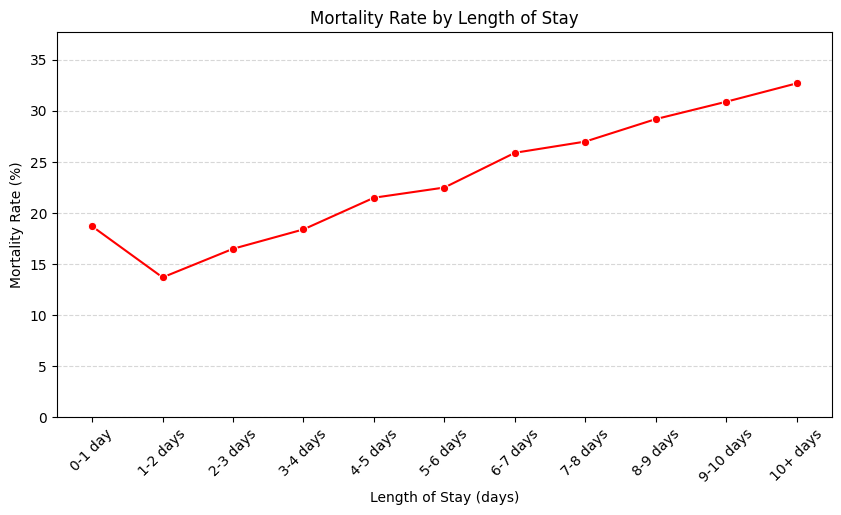

In [144]:
# Ensure LOS_group is ordered correctly
summary_table['LOS_group'] = pd.Categorical(
    summary_table['LOS_group'],
    categories=labels,
    ordered=True
)

# Plot line graph
plt.figure(figsize=(10,5))
sns.lineplot(
    data=summary_table,
    x='LOS_group',
    y='mortality_rate',
    marker='o',
    color='red'
)

plt.xticks(rotation=45)
plt.xlabel('Length of Stay (days)')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate by Length of Stay')
plt.ylim(0, summary_table['mortality_rate'].max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig('mortalityrate_prefiltered.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('mortalityrate_prefiltered.png')

plt.show()

In [146]:
# 1. Create LOS groups
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, df['LOS'].max()+1]  # 12 edges → 11 bins
labels = ['0-1 day', '1-2 days', '2-3 days', '3-4 days', '4-5 days', '5-6 days',
          '6-7 days', '7-8 days', '8-9 days', '9-10 days', '10+ days']  # 11 labels
df['LOS_group'] = pd.cut(df['LOS'], bins=bins, labels=labels, right=False)

# 2. Filter patients with APACHE < 30 (cut off set by LOS mortality rate by APACHE analysis)
df_filtered_low = df.copy()
mask = (df_filtered_low['LOS_group'] == '0-1 day') & (df_filtered_low['APACHE'] >= 30)
df_filtered_low = df_filtered_low[~mask].copy()

# 3. Group by LOS_group
summary_table = df_filtered_low.groupby('LOS_group').agg(
    n_patients=('Death', 'count'),
    n_deaths=('Death', 'sum')
).reset_index()

# 4. Calculate mortality rate
summary_table['mortality_rate'] = summary_table['n_deaths'] / summary_table['n_patients'] * 100
summary_table['mortality_rate'] = summary_table['mortality_rate'].round(1)

print(summary_table)

    LOS_group  n_patients  n_deaths  mortality_rate
0     0-1 day        6824       427             6.3
1    1-2 days       28492      3895            13.7
2    2-3 days       15159      2497            16.5
3    3-4 days        8671      1596            18.4
4    4-5 days        5356      1149            21.5
5    5-6 days        3481       784            22.5
6    6-7 days        2499       646            25.9
7    7-8 days        1860       502            27.0
8    8-9 days        1438       420            29.2
9   9-10 days        1145       354            30.9
10   10+ days        6728      2201            32.7


/tmp/ipython-input-1752805285.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df_filtered_low.groupby('LOS_group').agg(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

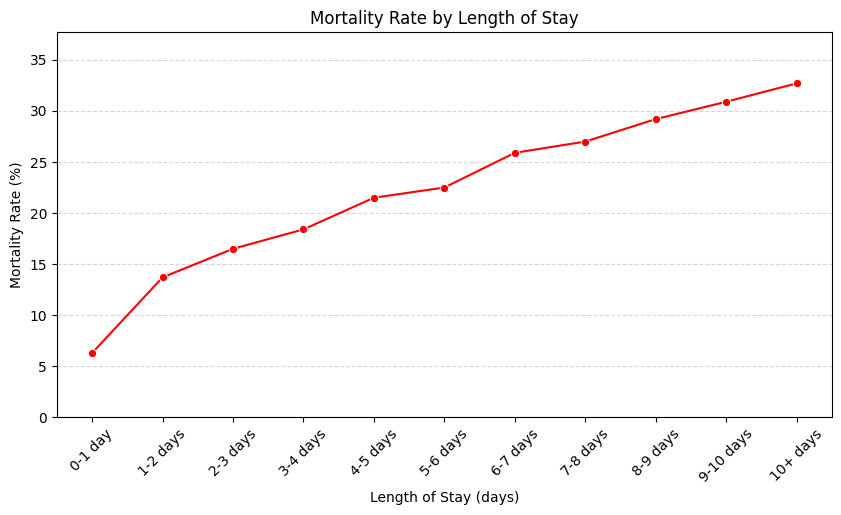

In [147]:
# Ensure LOS_group is ordered correctly
summary_table['LOS_group'] = pd.Categorical(
    summary_table['LOS_group'],
    categories=labels,
    ordered=True
)

# Plot line graph
plt.figure(figsize=(10,5))
sns.lineplot(
    data=summary_table,
    x='LOS_group',
    y='mortality_rate',
    marker='o',
    color='red'
)

plt.xticks(rotation=45)  # rotate x-axis labels for readability
plt.xlabel('Length of Stay (days)')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate by Length of Stay')
plt.ylim(0, summary_table['mortality_rate'].max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig('mortalityrate_filtered.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('mortalityrate_filtered.png')

plt.show()

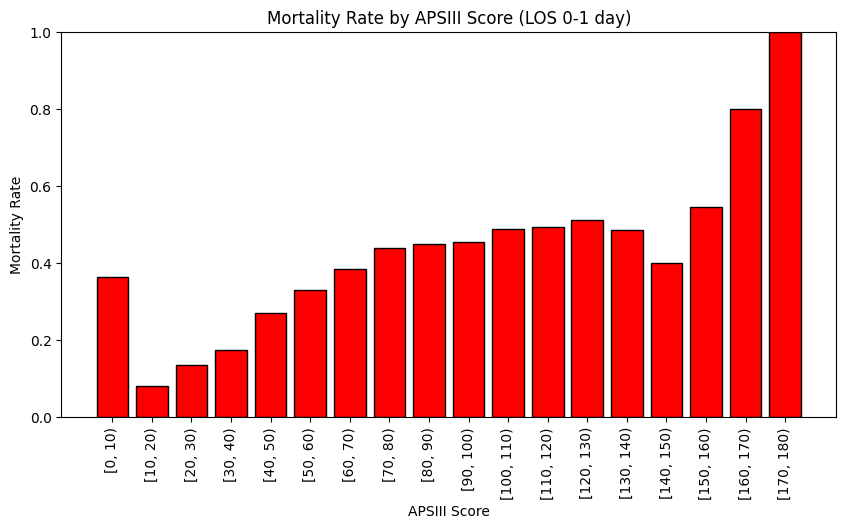

    APACHE_bin  n_patients  n_deaths  mortality_rate
0      [0, 10)          11         4        0.363636
1     [10, 20)         438        35        0.079909
2     [20, 30)        1381       186        0.134685
3     [30, 40)        2153       377        0.175105
4     [40, 50)        2550       688        0.269804
5     [50, 60)        2336       772        0.330479
6     [60, 70)        1758       676        0.384528
7     [70, 80)        1167       512        0.438732
8     [80, 90)         798       359        0.449875
9    [90, 100)         496       226        0.455645
10  [100, 110)         264       129        0.488636
11  [110, 120)         164        81        0.493902
12  [120, 130)          80        41          0.5125
13  [130, 140)          37        18        0.486486
14  [140, 150)          20         8             0.4
15  [150, 160)          11         6        0.545455
16  [160, 170)           5         4             0.8
17  [170, 180)           1         1          

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter LOS >= 6
df_6plus = df[df['LOS'] >= 6].copy()
df_6plus.head()

# 2. Bin APACHE scores
bin_width = 10
bins = np.arange(0, df_6plus['APACHE'].max() + bin_width, bin_width)
df_6plus['APACHE_bin'] = pd.cut(df_6plus['APACHE'], bins=bins, right=False)

# 3. Calculate mortality rate per bin
mortality_by_bin = df_6plus.groupby('APACHE_bin', observed=False)['Death'].mean().reset_index()

# 3b. Drop any NaN bins
mortality_by_bin = mortality_by_bin.dropna(subset=['APACHE_bin', 'Death'])

# 4. Plot mortality rate histogram
plt.figure(figsize=(10,5))
plt.bar(mortality_by_bin['APACHE_bin'].astype(str), mortality_by_bin['Death'],
        color='red', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('APSIII Score')
plt.ylabel('Mortality Rate')
plt.title('Mortality Rate by APSIII Score (LOS +6 day)')
plt.ylim(0, 1)
plt.show()

# 1. Count number of patients per bin
patients_per_bin = df_6plus.groupby('APACHE_bin', observed=False).agg(
    n_patients=('Death', 'count'),   # count all patients in the bin
    n_deaths=('Death', 'sum'),       # optional: sum of deaths
    mortality_rate=('Death', 'mean') # optional: mean = mortality rate
).reset_index()

# 2. Drop NaN bins if needed
patients_per_bin = patients_per_bin.dropna(subset=['APACHE_bin'])

# 3. Display
print(patients_per_bin)


In [ ]:
query= """
SELECT
  stay_id,
  COUNT(sofa_24hours) AS n_sofa_24hours_rows
FROM `physionet-data.mimiciv_3_1_derived.sofa`
WHERE sofa_24hours is not null
GROUP BY stay_id
ORDER BY n_sofa_24hours_rows DESC;

WITH icu AS (
  SELECT
    stay_id,
    subject_id,
    hadm_id,
    intime,
    outtime,
    los AS LOS
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
  WHERE outtime IS NOT NULL
    AND los > (2/24)
),

sex AS (
  SELECT subject_id, MAX(gender) AS gender
  FROM `physionet-data.mimiciv_3_1_hosp.patients`
  WHERE subject_id IN (SELECT subject_id FROM icu)
  GROUP BY subject_id
),

age AS (
  SELECT subject_id, MAX(age) AS age
  FROM `physionet-data.mimiciv_3_1_derived.age`
  WHERE subject_id IN (SELECT subject_id FROM icu)
  GROUP BY subject_id
),

apache AS (
  SELECT stay_id, MAX(apsiii) AS apache
  FROM `physionet-data.mimiciv_3_1_derived.apsiii`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
),

mechvent AS (
  SELECT stay_id, 1 AS mech_vent
  FROM `physionet-data.mimiciv_3_1_derived.ventilation`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
),

death AS (
  SELECT subject_id, MAX(hospital_expire_flag) AS died
  FROM `physionet-data.mimiciv_3_1_hosp.admissions`
  WHERE subject_id IN (SELECT subject_id FROM icu)
  GROUP BY subject_id
),

-- ⭐ NEW: MAX SOFA SCORE PER ICU STAY
sofa AS (
  SELECT
    stay_id,
    MAX(sofa_24hours) AS max_sofa
  FROM `physionet-data.mimiciv_3_1_derived.sofa`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
)

SELECT
  icu.stay_id,
  icu.subject_id,
  age.age,
  sex.gender,
  icu.los,
  apache.apache,
  sofa.max_sofa AS sofa,
  IFNULL(mechvent.mech_vent, 0) AS mech_vent,
  death.died
FROM icu
LEFT JOIN age USING (subject_id)
LEFT JOIN sex USING (subject_id)
LEFT JOIN apache USING (stay_id)
LEFT JOIN mechvent USING (stay_id)
LEFT JOIN sofa USING (stay_id)
LEFT JOIN death USING (subject_id);
"""

df = run_query(query)

df.head()

In [ ]:
# 1. Filter LOS >= 6
df_6plus = df[df['los'] >= 6].copy()
df_6plus.head()

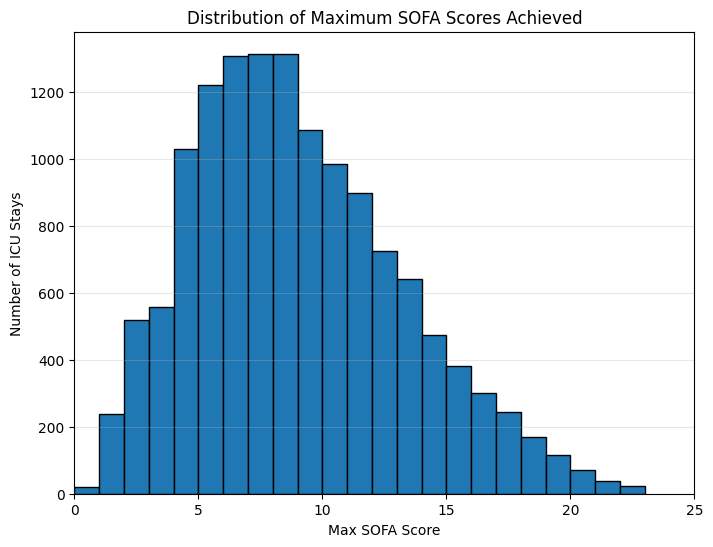

In [177]:
#Plot histogram of max SOFA Score
plt.figure(figsize=(8, 6))
plt.hist(df_6plus['sofa'], bins=23, edgecolor='black')
plt.xlabel("Max SOFA Score")
plt.xlim(0,25)
plt.ylabel("Number of ICU Stays")
plt.title("Distribution of Maximum SOFA Scores Achieved")
plt.grid(axis='y', alpha=0.3)

plt.show()

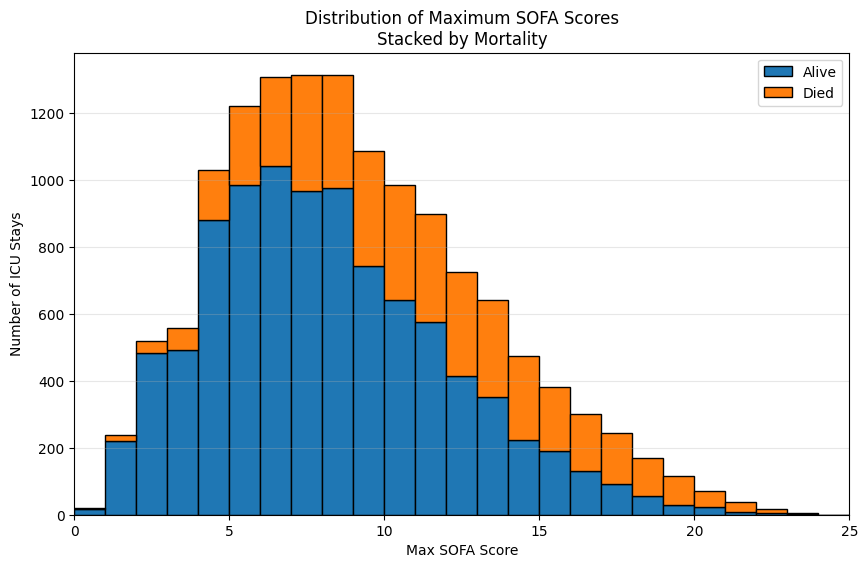

In [168]:
# Split data
alive = df_6plus[df_6plus['died'] == 0]['sofa']
dead  = df_6plus[df_6plus['died'] == 1]['sofa']

# Define bins
bins = range(0, 27, 1)   # 0–25 SOFA in 1-point bins

plt.figure(figsize=(10, 6))

# Stacked histogram
plt.hist(
    [alive, dead],
    bins=bins,
    stacked=True,
    label=['Alive', 'Died'],
    edgecolor='black'
)

plt.xlabel("Max SOFA Score")
plt.ylabel("Number of ICU Stays")
plt.title("Distribution of Maximum SOFA Scores\nStacked by Mortality")
plt.xlim(0, 25)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

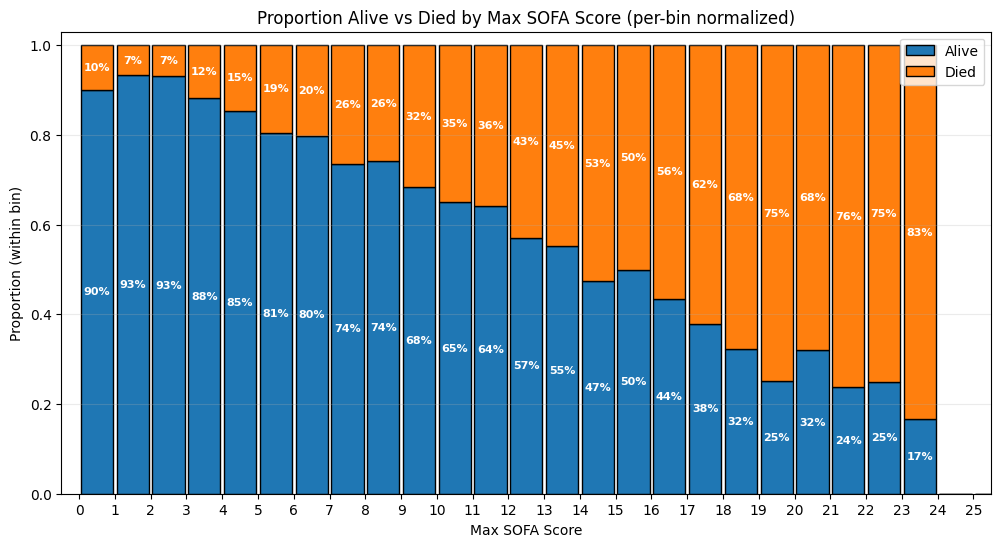

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# data
alive = df_6plus[df_6plus['died'] == 0]['sofa'].to_numpy()
dead  = df_6plus[df_6plus['died'] == 1]['sofa'].to_numpy()

# bins (0-25, 1-point bins)
bins = np.arange(0, 26 + 1, 1)   # edges: 0..26

# counts per bin for each group
alive_counts, _ = np.histogram(alive, bins=bins)
dead_counts,  _ = np.histogram(dead,  bins=bins)

# total counts per bin
total_counts = alive_counts + dead_counts

# avoid division by zero: if total=0, set proportions to 0
with np.errstate(divide='ignore', invalid='ignore'):
    alive_prop = np.where(total_counts > 0, alive_counts / total_counts, 0.0)
    dead_prop  = np.where(total_counts > 0, dead_counts  / total_counts, 0.0)

# x positions (bin centers)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = 0.9  # bar width

# plot stacked bar of proportions
plt.figure(figsize=(12, 6))
plt.bar(bin_centers, alive_prop, width=width, label='Alive',  edgecolor='black')
plt.bar(bin_centers, dead_prop,  width=width, bottom=alive_prop, label='Died', edgecolor='black')

plt.xlabel('Max SOFA Score')
plt.xlim(-0.5, 25.5)
plt.xticks(np.arange(0, 26, 1))
plt.ylim(0, 1.03)
plt.ylabel('Proportion (within bin)')
plt.title('Proportion Alive vs Died by Max SOFA Score (per-bin normalized)')
plt.legend()
plt.grid(axis='y', alpha=0.25)

# optional: show percentage labels inside bars
show_pct_labels = True
if show_pct_labels:
    for x, a_p, d_p, tot in zip(bin_centers, alive_prop, dead_prop, total_counts):
        if tot == 0:
            continue
        # alive percent label (centered in alive segment if large enough)
        if a_p > 0.06:
            plt.text(x, a_p/2, f"{a_p*100:.0f}%", ha='center', va='center', fontsize=8, color='white', fontweight='bold')
        else:
            # small segment: put label above segment
            plt.text(x, a_p/2, "", ha='center', va='center', fontsize=8)
        # died percent label
        if d_p > 0.06:
            plt.text(x, a_p + d_p/2, f"{d_p*100:.0f}%", ha='center', va='center', fontsize=8, color='white', fontweight='bold')

plt.show()


In [178]:
import numpy as np
import pandas as pd

# Extract sofa and mortality
alive = df_6plus[df_6plus['died'] == 0]['sofa']
dead  = df_6plus[df_6plus['died'] == 1]['sofa']

# Define bins 0–25 (26 bins)
bins = np.arange(0, 27, 1)

# Histogram counts
alive_counts, _ = np.histogram(alive, bins=bins)
dead_counts,  _ = np.histogram(dead,  bins=bins)

# Total counts
total_counts = alive_counts + dead_counts

# Bin labels (0,1,2,3,...25)
sofa_scores = bins[:-1]

# Build summary DataFrame
summary_table = pd.DataFrame({
    "SOFA Score": sofa_scores,
    "Alive": alive_counts,
    "Died": dead_counts,
    "Total": total_counts
})

summary_table


,SOFA Score,Alive,Died,Total
0,0,18,2,20
1,1,221,16,237
2,2,484,36,520
3,3,491,66,557
4,4,880,150,1030
5,5,984,238,1222
6,6,1042,264,1306
7,7,966,348,1314
8,8,975,338,1313
9,9,744,343,1087


In [ ]:
query= """

WITH icu AS (
  SELECT
    stay_id,
    subject_id,
    hadm_id,
    intime,
    outtime,
    los AS LOS
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
  WHERE outtime IS NOT NULL
    AND los > (2/24)
),

sex AS (
  SELECT subject_id, MAX(gender) AS gender
  FROM `physionet-data.mimiciv_3_1_hosp.patients`
  WHERE subject_id IN (SELECT stay_id FROM icu)
  GROUP BY subject_id
),

age AS (
  SELECT subject_id, MAX(age) AS age
  FROM `physionet-data.mimiciv_3_1_derived.age`
  WHERE subject_id IN (SELECT stay_id FROM icu)
  GROUP BY subject_id
),

apache AS (
  SELECT stay_id, MAX(apsiii) AS apache
  FROM `physionet-data.mimiciv_3_1_derived.apsiii`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
),

mechvent AS (
  SELECT stay_id, 1 AS mech_vent
  FROM `physionet-data.mimiciv_3_1_derived.ventilation`
  WHERE stay_id IN (SELECT stay_id FROM icu)
  GROUP BY stay_id
),

death AS (
  SELECT subject_id, MAX(hospital_expire_flag) AS died
  FROM `physionet-data.mimiciv_3_1_hosp.admissions`
  WHERE subject_id IN (SELECT subject_id FROM icu)  -- FIXED
  GROUP BY subject_id
),

-- SOFA measurements between 144–168 hr
sofa_6to7days AS (
  SELECT
    stay_id,
    hr,
    sofa_24hours AS sofa
  FROM `physionet-data.mimiciv_3_1_derived.sofa`
  WHERE stay_id IN (SELECT stay_id FROM icu)
    AND sofa_24hours IS NOT NULL
    AND hr BETWEEN 144 AND 168
),

-- Pull the first SOFA per stay in that window
first_sofa_6to7days AS (
  SELECT
    stay_id,
    FIRST_VALUE(sofa) OVER (PARTITION BY stay_id ORDER BY hr ASC) AS sofa,
    FIRST_VALUE(hr) OVER (PARTITION BY stay_id ORDER BY hr ASC) AS sofa_hr
  FROM sofa_6to7days
  QUALIFY ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY hr ASC) = 1
)

SELECT
  icu.stay_id,
  icu.subject_id,
  age.age,
  sex.gender,
  icu.los,
  apache.apache,
  first_sofa_6to7days.sofa,
  first_sofa_6to7days.sofa_hr,
  IFNULL(mechvent.mech_vent, 0) AS mech_vent,
  death.died
FROM icu
LEFT JOIN age USING (subject_id)
LEFT JOIN sex USING (subject_id)
LEFT JOIN apache USING (stay_id)
LEFT JOIN mechvent USING (stay_id)
LEFT JOIN death USING (subject_id)
LEFT JOIN first_sofa_6to7days USING (stay_id)
ORDER BY icu.stay_id;

"""

df = run_query(query)

df.head()

In [ ]:
# Remove rows where 'sofa' is NA/NaN
df_clean = df[df['sofa'].notna()]

# Check the first few rows
df_clean.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

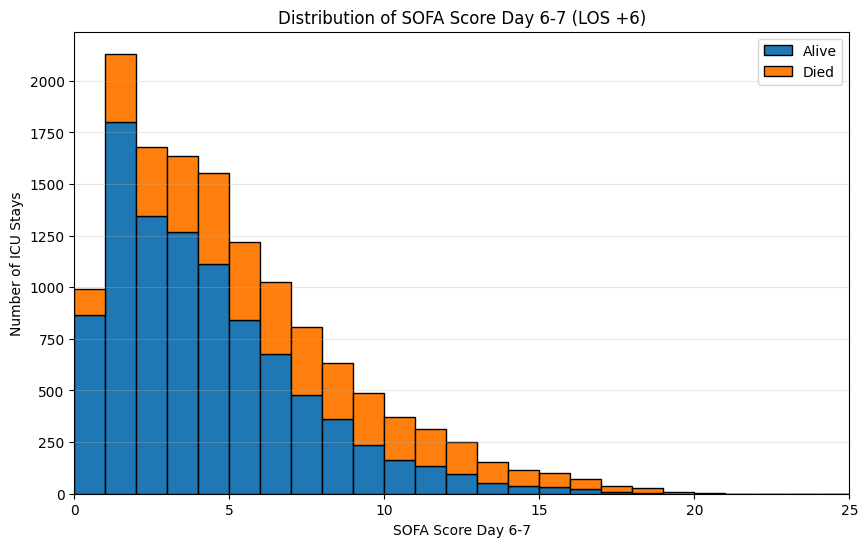

In [191]:
# Split data
df_clean = df_clean[df_clean['sofa'] != 21]

alive = df_clean[df_clean['died'] == 0]['sofa']
dead  = df_clean[df_clean['died'] == 1]['sofa']

# Define bins
bins = range(0, 27, 1)   # 0–25 SOFA in 1-point bins

plt.figure(figsize=(10, 6))

# Stacked histogram
plt.hist(
    [alive, dead],
    bins=bins,
    stacked=True,
    label=['Alive', 'Died'],
    edgecolor='black'
)

plt.xlabel("SOFA Score Day 6-7")
plt.ylabel("Number of ICU Stays")
plt.title("Distribution of SOFA Score Day 6-7 (LOS +6)")
plt.xlim(0, 25)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.savefig('SOFA_day6_7.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('SOFA_day6_7.png')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

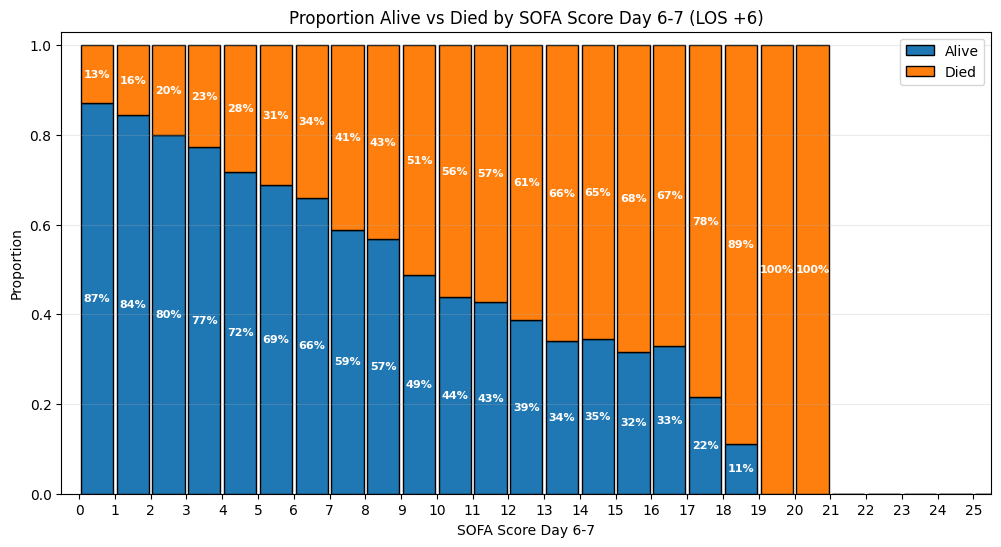

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# data
df_clean = df_clean[df_clean['sofa'] != 21]

alive = df_clean[df_clean['died'] == 0]['sofa'].to_numpy()
dead  = df_clean[df_clean['died'] == 1]['sofa'].to_numpy()

# bins (0-25, 1-point bins)
bins = np.arange(0, 26 + 1, 1)   # edges: 0..26

# counts per bin for each group
alive_counts, _ = np.histogram(alive, bins=bins)
dead_counts,  _ = np.histogram(dead,  bins=bins)

# total counts per bin
total_counts = alive_counts + dead_counts

# avoid division by zero: if total=0, set proportions to 0
with np.errstate(divide='ignore', invalid='ignore'):
    alive_prop = np.where(total_counts > 0, alive_counts / total_counts, 0.0)
    dead_prop  = np.where(total_counts > 0, dead_counts  / total_counts, 0.0)

# x positions (bin centers)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = 0.9  # bar width

# plot stacked bar of proportions
plt.figure(figsize=(12, 6))
plt.bar(bin_centers, alive_prop, width=width, label='Alive',  edgecolor='black')
plt.bar(bin_centers, dead_prop,  width=width, bottom=alive_prop, label='Died', edgecolor='black')

plt.xlabel('SOFA Score Day 6-7')
plt.xlim(-0.5, 25.5)
plt.xticks(np.arange(0, 26, 1))
plt.ylim(0, 1.03)
plt.ylabel('Proportion')
plt.title('Proportion Alive vs Died by SOFA Score Day 6-7 (LOS +6)')
plt.legend()
plt.grid(axis='y', alpha=0.25)

# optional: show percentage labels inside bars
show_pct_labels = True
if show_pct_labels:
    for x, a_p, d_p, tot in zip(bin_centers, alive_prop, dead_prop, total_counts):
        if tot == 0:
            continue
        # alive percent label (centered in alive segment if large enough)
        if a_p > 0.06:
            plt.text(x, a_p/2, f"{a_p*100:.0f}%", ha='center', va='center', fontsize=8, color='white', fontweight='bold')
        else:
            # small segment: put label above segment
            plt.text(x, a_p/2, "", ha='center', va='center', fontsize=8)
        # died percent label
        if d_p > 0.06:
            plt.text(x, a_p + d_p/2, f"{d_p*100:.0f}%", ha='center', va='center', fontsize=8, color='white', fontweight='bold')

plt.savefig('SOFA_day6_7_norm.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('SOFA_day6_7_norm.png')

plt.show()

In [186]:
import numpy as np
import pandas as pd

# Extract sofa and mortality
alive = df_clean[df_clean['died'] == 0]['sofa']
dead  = df_clean[df_clean['died'] == 1]['sofa']

# Define bins 0–25 (26 bins)
bins = np.arange(0, 27, 1)

# Histogram counts
alive_counts, _ = np.histogram(alive, bins=bins)
dead_counts,  _ = np.histogram(dead,  bins=bins)

# Total counts
total_counts = alive_counts + dead_counts

# Bin labels (0,1,2,3,...25)
sofa_scores = bins[:-1]

# Build summary DataFrame
summary_table = pd.DataFrame({
    "SOFA Score": sofa_scores,
    "Alive": alive_counts,
    "Died": dead_counts,
    "Total": total_counts
})

summary_table

,SOFA Score,Alive,Died,Total
0,0,864,129,993
1,1,1799,332,2131
2,2,1344,335,1679
3,3,1267,371,1638
4,4,1115,439,1554
5,5,839,380,1219
6,6,677,350,1027
7,7,476,333,809
8,8,360,275,635
9,9,237,249,486
